# LLM - VOID

# 1. Setup & Dependencies

## 1.1 Install Dependencies

In [1]:
!pip install tiktoken

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import matplotlib.pyplot as plt
import urllib.request

# 2. GPT Architecture Components

## 2.1 Multi-Head Self-Attention

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

## 2.2 Layer Normalization

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


## 2.3 GELU Activation

In [56]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


## 2.4 Feedforward Network

In [57]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

## 2.5 Transformer Block

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

## 2.6 GPT Model Definition

In [6]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## 2.7 Base Configuration & Parameter Count

In [7]:
GPT_CONFIG = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024,
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate":0.15,      # Dropout rate
    "qkv_bias": True      # Query-key-value bias
}

In [8]:
model = GPTModel(GPT_CONFIG)
num_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", num_params)

Total number of parameters: 163037184


# 3. Load Pretrained GPT-2 Weights

In [9]:
pip install tensorflow>=2.15.0 tqdm>=4.66

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 which is incompatible.
Note: you may need to restart the kernel to use updated pac

In [10]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

2025-12-10 13:41:49.097902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765374109.315059      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765374109.376472      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
tqdm version: 4.67.1


## 3.1 Import GPT-2 Download Helper

In [11]:
import sys
sys.path.append('/kaggle/input/gpt-download3-py')

In [12]:
from gpt_download3 import download_and_load_gpt2

In [13]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 146kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 7.98MiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [14]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## 3.2 Model Configurations

In [15]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.15,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

File already exists and is up-to-date: gpt2/124M/checkpoint


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## 3.3 Sanity Check Config Match

In [16]:
print(settings["n_vocab"] == BASE_CONFIG["vocab_size"])      # True or False
print(settings["n_ctx"] == BASE_CONFIG["context_length"])     # True or False
print(settings["n_embd"] == BASE_CONFIG["emb_dim"])           # True or False
print(settings["n_head"] == BASE_CONFIG["n_heads"])           # True or False
print(settings["n_layer"] == BASE_CONFIG["n_layers"])         # True or False

True
True
True
True
True


## 3.4 Weight Assignment Helper

In [17]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

## 3.5 Load Weights into Custom GPT

In [18]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## 3.6 Instantiate Model & Move to Device

In [19]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.15, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.15, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [22]:
print(next(model.parameters()).device)        # should be your device
print(model.pos_emb.weight.shape, params["wpe"].shape)
print(model.tok_emb.weight.shape, params["wte"].shape)
print(len(params["blocks"]), len(model.trf_blocks))

cuda:0
torch.Size([1024, 768]) (1024, 768)
torch.Size([50257, 768]) (50257, 768)
12 12


## 3.7 Check Maximum Differences (Verification)

In [23]:
import torch

def max_diff(t, arr):
    arr_t = torch.tensor(arr, dtype=t.dtype, device=t.device)
    return (t.detach() - arr_t).abs().max().item()

print("pos_emb max diff:", max_diff(model.pos_emb.weight, params["wpe"]))
print("tok_emb max diff:", max_diff(model.tok_emb.weight, params["wte"]))
print("out_head max diff:", max_diff(model.out_head.weight, params["wte"]))

pos_emb max diff: 0.0
tok_emb max diff: 0.0
out_head max diff: 0.0


In [24]:
b = 0  # first block
q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)

print("block0 Q max diff:", max_diff(model.trf_blocks[b].att.W_query.weight, q_w.T))
print("block0 K max diff:", max_diff(model.trf_blocks[b].att.W_key.weight,   k_w.T))
print("block0 V max diff:", max_diff(model.trf_blocks[b].att.W_value.weight, v_w.T))

block0 Q max diff: 0.0
block0 K max diff: 0.0
block0 V max diff: 0.0


# 4. Text Generation Utilities (Pre-Finetuning Sanity Check)

In [58]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

import tiktoken

## 4.1 Tokenizer Helpers

In [59]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

## 4.2 Quick Generation Test

In [60]:
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as a result.

### Instruction:
Reply in a way that sounds like genuine, everyday conversation.

###


# 5. Instruction Dataset Loading & Formatting

## 5.1 Load JSON Dataset

In [26]:
import json

# Import the JSON file
with open('/kaggle/input/training-dataset-json/training_dataset.json', 'r') as f:
    data = json.load(f)

# Print number of entries
print(f"Total number of entries: {len(data)}")

Total number of entries: 40000


In [27]:
# # Assuming 'data' is a list or similar iterable containing all your entries
# desired_size = 25000

# # If your dataset is larger than desired_size, keep first 20,000 entries
# if len(data) > desired_size:
#     data = data[:desired_size]
#     print(f"Data truncated to {desired_size} entries.")
# else:
#     print(f"Data size {len(data)} is less than {desired_size}, no truncation needed.")

In [28]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Respond naturally, as if talking to someone you know and like.', 'input': 'Did your meeting go well?', 'output': 'Yeah, it went well! Everyone was on the same page, which is always nice.'}


In [29]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "Respond in a manner that's genuine, casual, and easy to understand.", 'input': 'Do you call your parents often?', 'output': 'I try to call them at least once a week, maybe more. How often do you?'}


## 5.2 Prompt Formatting

In [30]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [31]:
model_input = format_input(data[44])
desired_response = f"\n\n### Response:\n{data[44]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Respond with a friendly tone that matches normal everyday conversation.

### Input:
The humidity is unbearable right now.

### Response:
Oh man, tell me about it! It's been hard to cool down even at night.


## 5.3 Train/Val/Test Split

In [32]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [33]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 34000
Validation set length: 2000
Test set length: 4000


# 6. PyTorch Dataset & Dataloaders

## 6.1 InstructionDataset

In [34]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

## 6.2 Custom Collate Function

In [35]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [36]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=256)

## 6.3 Dataloaders

In [37]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [38]:
# print("Train loader:")
# for inputs, targets in train_loader:
#     print(inputs.shape, targets.shape)

# 7. Training Utilities

## 7.1 Loss Calculation

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

## 7.2 Simple Greedy Generation (Training Preview)

In [40]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

## 7.3 Sample Generation Helper

In [41]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

## 7.4 Early Stopping

In [42]:
class EarlyStopping:
    """
    Stops training when validation loss stops improving.
    
    Args:
        patience (int): How many evaluations to wait before stopping
        min_delta (float): Minimum change to qualify as improvement
        restore_best_weights (bool): Whether to restore best model weights
    """
    def __init__(self, patience=3, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        """
        Check if training should stop.
        
        Returns:
            True if training should stop, False otherwise
        """
        # Check if validation loss improved
        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.patience_counter = 0
            # Save the best model weights
            self.best_weights = {k: v.clone() for k, v in model.state_dict().items()}
            return False  # Continue training
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print(f"Early stopping triggered! Best val loss: {self.best_loss:.4f}")
                # Restore best weights if requested
                if self.restore_best_weights and self.best_weights:
                    model.load_state_dict(self.best_weights)
                    print("Restored best model weights")
                return True  # Stop training
            return False  # Continue training

## 7.5 Evaluation Helper

In [44]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

## 7.6 Training Loop with Early Stopping

In [43]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer, 
                       early_stopping=None):  # ADD THIS PARAMETER
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
                # ADD EARLY STOPPING CHECK HERE
                if early_stopping is not None:
                    if early_stopping(val_loss, model):
                        print(f"Stopping training at epoch {epoch+1}, step {global_step}")
                        return train_losses, val_losses, track_tokens_seen

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, val_losses, track_tokens_seen

## 7.7 Loss Plotting

In [45]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.show()

# 8. GPU Memory Diagnostics & Training Run

## 8.1 GPU Fragmentation Mitigation

In [46]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch
torch.cuda.empty_cache()
print("GPU fragmentation fix enabled")

GPU fragmentation fix enabled


## 8.2 GPU Memory Status

In [47]:
import torch

print("CUDA MEMORY STATUS")

# Total GPU memory
total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"Total GPU Memory: {total_memory:.2f} GB")

# Current usage
allocated = torch.cuda.memory_allocated() / 1e9
cached = torch.cuda.memory_reserved() / 1e9
print(f"Allocated: {allocated:.2f} GB")
print(f"Cached:    {cached:.2f} GB")
print(f"Free:      {total_memory - allocated:.2f} GB")

# Usage percentage
usage_pct = (allocated / total_memory) * 100
print(f"Usage:     {usage_pct:.1f}%")

CUDA MEMORY STATUS
Total GPU Memory: 15.83 GB
Allocated: 0.72 GB
Cached:    0.75 GB
Free:      15.11 GB
Usage:     4.5%


## 8.3 Launch Training

In [48]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.15)

num_epochs = 1

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=10,              # Stop if val loss doesn't improve for 3 evaluations
    min_delta=0.0001,        # Minimum improvement threshold
    restore_best_weights=True  # Restore best model weights when stopping
)

# Train with early stopping
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=100, eval_iter=10,
    start_context=format_input(val_data[0]), tokenizer=tokenizer, early_stopping=early_stopping  # ADD THIS
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.612, Val loss 3.386
Ep 1 (Step 000100): Train loss 1.734, Val loss 2.311
Ep 1 (Step 000200): Train loss 1.488, Val loss 2.091
Ep 1 (Step 000300): Train loss 1.261, Val loss 1.842
Ep 1 (Step 000400): Train loss 0.856, Val loss 1.586
Ep 1 (Step 000500): Train loss 0.824, Val loss 1.385
Ep 1 (Step 000600): Train loss 0.576, Val loss 1.243
Ep 1 (Step 000700): Train loss 0.553, Val loss 1.089
Ep 1 (Step 000800): Train loss 0.382, Val loss 0.967
Ep 1 (Step 000900): Train loss 0.320, Val loss 0.829
Ep 1 (Step 001000): Train loss 0.291, Val loss 0.716
Ep 1 (Step 001100): Train loss 0.340, Val loss 0.650
Ep 1 (Step 001200): Train loss 0.336, Val loss 0.567
Ep 1 (Step 001300): Train loss 0.235, Val loss 0.481
Ep 1 (Step 001400): Train loss 0.237, Val loss 0.399
Ep 1 (Step 001500): Train loss 0.306, Val loss 0.315
Ep 1 (Step 001600): Train loss 0.167, Val loss 0.294
Ep 1 (Step 001700): Train loss 0.203, Val loss 0.292
Ep 1 (Step 001800): Train loss 0.180, Val loss

## 8.4 Plot Loss Curves

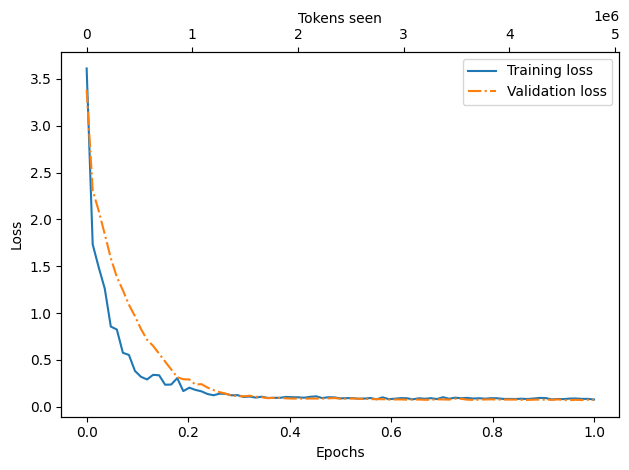

In [49]:
import matplotlib.pyplot as plt
import torch

# epochs_seen: linearly spaced from 0 to num_epochs
epochs_seen = torch.linspace(0, num_epochs, len(train_losses))

# Create the plot
plot_losses(epochs_seen, tokens_seen, train_losses, val_losses)

# Show it in the notebook
plt.show()

# 9. Save Fine-Tuned Model

In [50]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium124M-sft.pth"))

Model saved as gpt2-small124M-sft.pth


# 10. Inference & Chat Interface

In [51]:
class ModelInference:
    def __init__(self, model, tokenizer, device, base_config):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.context_length = base_config['context_length']
        self.model.eval()
    
    def format_prompt(self, user_input):
        return f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

Instruction: {user_input}
Response: """
    
    def generate(self, user_input, max_new_tokens=100, temperature=0.7, top_k=50):
        formatted_prompt = self.format_prompt(user_input)
        input_ids = self.tokenizer.encode(formatted_prompt)
        input_tensor = torch.tensor(input_ids).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output_ids = generate(model=self.model, idx=input_tensor, max_new_tokens=max_new_tokens, context_size=self.context_length, temperature=temperature, top_k=top_k)
        
        response = self.tokenizer.decode(output_ids[0].tolist())
        if "Response:" in response:
            response = response.split("Response:")[-1].strip()
        return response
    
    def chat(self, max_new_tokens=100, temperature=0.7):
        print("\n" + "="*80 + "\n CHAT MODE | Type 'exit' to quit\n" + "="*80 + "\n")
        while True:
            user_input = input("You: ").strip()
            if user_input.lower() in ['exit', 'quit']:
                print("\nGoodbye!")
                break
            if not user_input:
                continue
            print("\n Thinking...", end='', flush=True)
            response = self.generate(user_input, max_new_tokens, temperature)
            print("\r" + " "*30 + "\r", end='')
            print(f"Model: {response}\n")

In [55]:
questions = [
    "I want to learn a new skill but I'm not sure where to start or if it's worth my time.",
    "How should I handle a friend who keeps borrowing money and not paying me back?",
    "I'm thinking about changing careers but I'm worried about starting over. Is it worth it?",
    "How do I set healthy boundaries with family members who are very demanding?",
    "Can you explain how machine learning models are actually trained?",
]

for q in questions:
    print("You:", q)
    print("Model:", inference.generate(q))
    print()


You: I want to learn a new skill but I'm not sure where to start or if it's worth my time.
Model: ~~ Instruction:
Learning something new is always worth the investment in yourself. Start small: commit to just 15-30 minutes a day rather than overwhelming yourself. Find the best format for you—some people learn by doing, others by watching videos, others by reading. There are countless free resources available. Pick one skill, give it a real try for a month, and see if it sparks joy. If it does, keep going. If not, no harm done.<|endoftext|>The author builds tension

You: How should I handle a friend who keeps borrowing money and not paying me back?
Model: This is a tough situation that requires direct but kind communication. You might say, 'I care about our friendship, but I can't keep lending money. Let's figure out what you actually need help with.' Set a clear boundary: you're not a bank, but you might help with budgeting, job searching, or other solutions. True friends will respect 